In [1]:
from google.colab import files

uploaded = files.upload()  # این خط یک پنجره باز می‌کنه برای آپلود فایل‌ها


Saving clean_gas.csv to clean_gas.csv
Saving clean_urea.csv to clean_urea.csv
Saving clean_wheat.csv to clean_wheat.csv


In [4]:
# =========================
# Full robust pipeline: load -> inspect -> preprocess -> monthly merge
# =========================

import os
from pathlib import Path
import pandas as pd
import numpy as np
from functools import reduce

# --------- helper: try to find file or ask to upload (works in Colab) ----------
def find_existing(candidates):
    for p in candidates:
        if Path(p).exists():
            return p
    return None

def try_colab_upload(missing_names):
    # only attempt if running in Colab
    try:
        from google.colab import files as colab_files
    except Exception:
        return {}
    print("Files not found locally. Please upload the missing files via the dialog.")
    uploaded = colab_files.upload()
    return {name: fname for fname in uploaded.keys() for name in missing_names if name in fname.lower()}

# --------- candidate filenames (edit if your filenames differ) -------------
urea_candidates  = ["clean_urea.csv", "urea.csv", "urea_clean.csv"]
gas_candidates   = ["clean_gas.csv", "gas.csv", "gas_clean.csv"]
wheat_candidates = ["clean_wheat.csv", "wheat.csv", "wheat_clean.csv"]

# find files
urea_file  = find_existing(urea_candidates)
gas_file   = find_existing(gas_candidates)
wheat_file = find_existing(wheat_candidates)

missing = []
if not urea_file: missing.append("urea")
if not gas_file: missing.append("gas")
if not wheat_file: missing.append("wheat")

# if any missing, try Colab upload
upload_map = {}
if missing:
    upload_map = try_colab_upload(missing)

# map uploaded -> use uploaded filename if present
if not urea_file:
    for k in upload_map:
        if "urea" in k.lower():
            urea_file = k
if not gas_file:
    for k in upload_map:
        if "gas" in k.lower():
            gas_file = k
if not wheat_file:
    for k in upload_map:
        if "wheat" in k.lower():
            wheat_file = k

# final check
if not (urea_file and gas_file and wheat_file):
    raise FileNotFoundError(f"Files not found. urea: {urea_file}, gas: {gas_file}, wheat: {wheat_file}. "
                            "Put them in working dir or upload via Colab.")

print("Using files:")
print(" - urea:", urea_file)
print(" - gas: ", gas_file)
print(" - wheat:", wheat_file)

# =======================
# 1) Load raw files & quick inspect
# =======================
urea  = pd.read_csv(urea_file)
gas   = pd.read_csv(gas_file)
wheat = pd.read_csv(wheat_file)

print("\n--- QUICK INSPECT ---")
def quick_inspect(name, df, n=3):
    print(f"\n[{name}] shape: {df.shape}")
    print(" Columns:", df.columns.tolist())
    print(" dtypes:\n", df.dtypes)
    print(" head:")
    print(df.head(n))
    print(" missing (top cols):")
    print(df.isnull().sum().sort_values(ascending=False).head(10))
    print(" numeric describe:")
    print(df.select_dtypes(include=[np.number]).describe().T[['count','mean','std','min','max']])

quick_inspect("UREA", urea)
quick_inspect("GAS", gas)
quick_inspect("WHEAT", wheat)

# =======================
# 2) Preprocess each dataset (safe)
# =======================

# ---- UREA ----
# try known date columns
urea = urea.copy()
date_col_urea = None
for c in ["Date", "date", "Exp Date", "Exp_Date", "ExpDate"]:
    if c in urea.columns:
        date_col_urea = c
        break
if date_col_urea is None:
    raise ValueError("UREA: no date column found. Expected 'Date' or 'Exp Date'.")

urea['Date'] = pd.to_datetime(urea[date_col_urea], errors='coerce')
# numeric price column expected 'Urea_Price' from your sample
if 'Urea_Price' not in urea.columns:
    # try to guess numeric columns other than Date
    possible = [c for c in urea.columns if pd.api.types.is_numeric_dtype(urea[c]) and c.lower().find('price')!=-1]
    if possible:
        price_col = possible[0]
        urea.rename(columns={price_col: 'Urea_Price'}, inplace=True)
    else:
        raise ValueError("UREA: price column not found (expected 'Urea_Price').")
# ensure numeric
urea['Urea_Price'] = pd.to_numeric(urea['Urea_Price'], errors='coerce')

# drop rows with invalid Date
urea = urea.dropna(subset=['Date']).copy()
# if multiple rows same date, aggregate by mean
urea_monthly = urea[['Date','Urea_Price']].groupby(pd.Grouper(key='Date', freq='MS')).mean().reset_index()

# ---- GAS ----
gas = gas.copy()
# possible date columns: 'Month' (1997-01-01), or Year+Month_Num
if 'Month' in gas.columns:
    gas['Date'] = pd.to_datetime(gas['Month'], errors='coerce')
elif 'Year' in gas.columns and any(c.lower().startswith('month') for c in gas.columns):
    # find month column name
    month_col = None
    for c in gas.columns:
        if c.lower() in ('month_num','monthnum','month_no','month'):
            month_col = c
            break
        if 'month' in c.lower() and c!= 'Month':
            month_col = c
    if month_col is None:
        # try Month_Num specifically
        month_col = 'Month_Num' if 'Month_Num' in gas.columns else None
    if month_col:
        gas['Month_Num'] = pd.to_numeric(gas[month_col], errors='coerce').astype('Int64')
        gas['Date'] = pd.to_datetime(gas['Year'].astype(str) + '-' + gas['Month_Num'].astype(str).str.zfill(2) + '-01', errors='coerce')
    else:
        gas['Date'] = pd.to_datetime(gas['Year'].astype(str) + '-01-01', errors='coerce')
elif 'Year' in gas.columns:
    gas['Date'] = pd.to_datetime(gas['Year'].astype(str) + '-01-01', errors='coerce')
else:
    raise ValueError("GAS: cannot build a 'Date' column from your dataset")

# ensure gas price numeric
if 'Gas_Price' not in gas.columns:
    # guess
    candidates = [c for c in gas.columns if 'price' in c.lower() or pd.api.types.is_numeric_dtype(gas[c])]
    if candidates:
        gas.rename(columns={candidates[0]:'Gas_Price'}, inplace=True)
    else:
        raise ValueError("GAS: price column not found.")
gas['Gas_Price'] = pd.to_numeric(gas['Gas_Price'], errors='coerce')
gas = gas.dropna(subset=['Date']).copy()
gas_monthly = gas[['Date','Gas_Price']].groupby(pd.Grouper(key='Date', freq='MS')).mean().reset_index()

# ---- WHEAT ----
wheat = wheat.copy()
# prefer 'Year' numeric
if 'Year' in wheat.columns:
    wheat['Year'] = pd.to_numeric(wheat['Year'], errors='coerce').astype('Int64')
else:
    # try to extract year from Marketing_Year like '1866/67'
    if 'Marketing_Year' in wheat.columns:
        wheat['Year'] = wheat['Marketing_Year'].astype(str).str.extract(r'(\d{4})')[0].astype(float).astype('Int64')
    else:
        raise ValueError("WHEAT: no 'Year' or 'Marketing_Year' column found.")

# ensure Amount numeric
if 'Amount' not in wheat.columns:
    # try to guess numeric column
    nums = [c for c in wheat.columns if pd.api.types.is_numeric_dtype(wheat[c])]
    if nums:
        wheat.rename(columns={nums[0]:'Amount'}, inplace=True)
    else:
        raise ValueError("WHEAT: no Amount numeric column found.")
wheat['Amount'] = pd.to_numeric(wheat['Amount'], errors='coerce')

# aggregate per year (because wheat has multiple commodity rows per year)
wheat_yearly = wheat.groupby('Year', as_index=False)['Amount'].mean()
# create monthly frame from min->max year
start_year = int(wheat_yearly['Year'].min())
end_year   = int(wheat_yearly['Year'].max())
monthly_dates = pd.date_range(start=f"{start_year}-01-01", end=f"{end_year}-12-01", freq='MS')
wheat_monthly = pd.DataFrame({'Date': monthly_dates})
wheat_monthly['Year'] = wheat_monthly['Date'].dt.year
wheat_monthly = wheat_monthly.merge(wheat_yearly, on='Year', how='left')
wheat_monthly = wheat_monthly[['Date','Amount']].copy()

# If some years have no Amount, keep NaN for now.

# ================
# 3) Merge monthly frames
# ================
dfs = [wheat_monthly.rename(columns={'Amount':'Wheat_Amount'}),
       urea_monthly.rename(columns={'Urea_Price':'Urea_Price'}),
       gas_monthly.rename(columns={'Gas_Price':'Gas_Price'})]

merged = reduce(lambda left, right: pd.merge(left, right, on='Date', how='outer'), dfs)
merged = merged.sort_values('Date').reset_index(drop=True)
merged['YearMonth'] = merged['Date'].dt.to_period('M').astype(str)

print("\nMerged (raw) preview:")
print(merged.head(12))
print("\nMissing counts (before overlap trim):")
print(merged[['Wheat_Amount','Urea_Price','Gas_Price']].isna().sum())

# ================
# 4) compute overlap (first & last non-null per column)
# ================
def first_last_nonnull(df, col):
    mask = df[col].notna()
    if not mask.any():
        return (None,None)
    mn = df.loc[mask,'Date'].min()
    mx = df.loc[mask,'Date'].max()
    return (mn,mx)

ranges = {col: first_last_nonnull(merged, col) for col in ['Wheat_Amount','Urea_Price','Gas_Price']}
print("\nData availability per column (first->last):")
for k,v in ranges.items():
    print(f" - {k}: {v[0]} -> {v[1]}")

valid_starts = [r[0] for r in ranges.values() if r[0] is not None]
valid_ends   = [r[1] for r in ranges.values() if r[1] is not None]

if valid_starts and valid_ends:
    overlap_start = max(valid_starts)
    overlap_end   = min(valid_ends)
    print("\nComputed overlap:", overlap_start, "→", overlap_end)
else:
    overlap_start = overlap_end = None
    print("\nNo valid date ranges found to compute overlap.")

# ================
# 5) if overlap exists and is reasonable (>= 12 months) -> trim monthly and interpolate
# ================
def fill_timewise(df):
    df2 = df.set_index('Date').sort_index()
    # interpolate based on time
    df2[['Wheat_Amount','Urea_Price','Gas_Price']] = df2[['Wheat_Amount','Urea_Price','Gas_Price']].interpolate(method='time')
    df2[['Wheat_Amount','Urea_Price','Gas_Price']] = df2[['Wheat_Amount','Urea_Price','Gas_Price']].ffill().bfill()
    df2 = df2.reset_index()
    return df2

df_final_monthly = None
if (overlap_start is not None) and (overlap_start <= overlap_end):
    # measure overlap length in months
    months = (overlap_end.to_period('M') - overlap_start.to_period('M')).n
    if months >= 12:
        df_trim = merged[(merged['Date']>=overlap_start) & (merged['Date']<=overlap_end)].copy()
        df_final_monthly = fill_timewise(df_trim)
        print(f"\nTrimmed to overlap period ({months} months) and filled NaNs. Final shape: {df_final_monthly.shape}")
    else:
        print(f"\nOverlap length is {months} months (< 12). Will produce both monthly (if possible) and yearly fallback.")
else:
    print("\nNo valid overlap - will produce yearly aggregation fallback.")

# ================
# 6) Yearly fallback (aggregate to Year) - always produce as fallback
# ================
# urea_yearly, gas_yearly from monthly frames (if exist)
try:
    urea_yearly = urea_monthly.set_index('Date').resample('Y').mean().reset_index()
    gas_yearly  = gas_monthly.set_index('Date').resample('Y').mean().reset_index()
    urea_yearly['Year'] = urea_yearly['Date'].dt.year
    gas_yearly['Year']  = gas_yearly['Date'].dt.year
    wheat_yearly2 = wheat_yearly.copy()  # Year & Amount
    # merge on Year
    yearly = wheat_yearly2.merge(urea_yearly[['Year','Urea_Price']], on='Year', how='left')
    yearly = yearly.merge(gas_yearly[['Year','Gas_Price']], on='Year', how='left')
    yearly = yearly.sort_values('Year').reset_index(drop=True)
    # fill small gaps by interpolation of numeric Year index
    yearly[['Amount','Urea_Price','Gas_Price']] = yearly[['Amount','Urea_Price','Gas_Price']].interpolate().ffill().bfill()
    yearly.rename(columns={'Amount':'Wheat_Amount'}, inplace=True)
    print("\nYearly merged preview:")
    print(yearly.head(8))
except Exception as e:
    print("\nYearly fallback generation failed:", e)
    yearly = None

# ================
# 7) Save outputs
# ================
out_monthly_file = "merged_monthly_prepared.csv"
out_yearly_file  = "merged_yearly_prepared.csv"

if df_final_monthly is not None:
    df_final_monthly.to_csv(out_monthly_file, index=False)
    print(f"\nSaved monthly prepared CSV -> {out_monthly_file}")
else:
    print("\nNo sufficiently long monthly overlap to produce a reliable monthly merged file.")

if yearly is not None:
    yearly.to_csv(out_yearly_file, index=False)
    print(f"Saved yearly prepared CSV -> {out_yearly_file}")

# final status summary
print("\n--- SUMMARY ---")
print("Monthly file created:" , os.path.exists(out_monthly_file))
print("Yearly file created:"  , os.path.exists(out_yearly_file))
print("\nIf both False, check earlier error messages and file names.")


Using files:
 - urea: clean_urea.csv
 - gas:  clean_gas.csv
 - wheat: clean_wheat.csv

--- QUICK INSPECT ---

[UREA] shape: (87, 12)
 Columns: ['Exp Date', 'Symbol', 'Contract Name', 'Urea_Price', '52W High', '52W High Date', '52W Low', '52W Low Date', '52W %Chg', 'Date', 'Year', 'Month']
 dtypes:
 Exp Date          object
Symbol            object
Contract Name     object
Urea_Price       float64
52W High         float64
52W High Date     object
52W Low          float64
52W Low Date      object
52W %Chg          object
Date              object
Year             float64
Month            float64
dtype: object
 head:
     Exp Date Symbol                            Contract Name  Urea_Price  \
0  2019-07-25  JCN19       Urea FOB US Gulf July 2019 Futures      249.63   
1  2019-08-29  JCQ19     Urea FOB US Gulf August 2019 Futures      253.10   
2  2019-09-26  JCU19  Urea FOB US Gulf September 2019 Futures      251.00   

   52W High 52W High Date  52W Low 52W Low Date 52W %Chg        Date  

/tmp/ipython-input-3292192929.py:274: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  urea_yearly = urea_monthly.set_index('Date').resample('Y').mean().reset_index()
/tmp/ipython-input-3292192929.py:275: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  gas_yearly  = gas_monthly.set_index('Date').resample('Y').mean().reset_index()


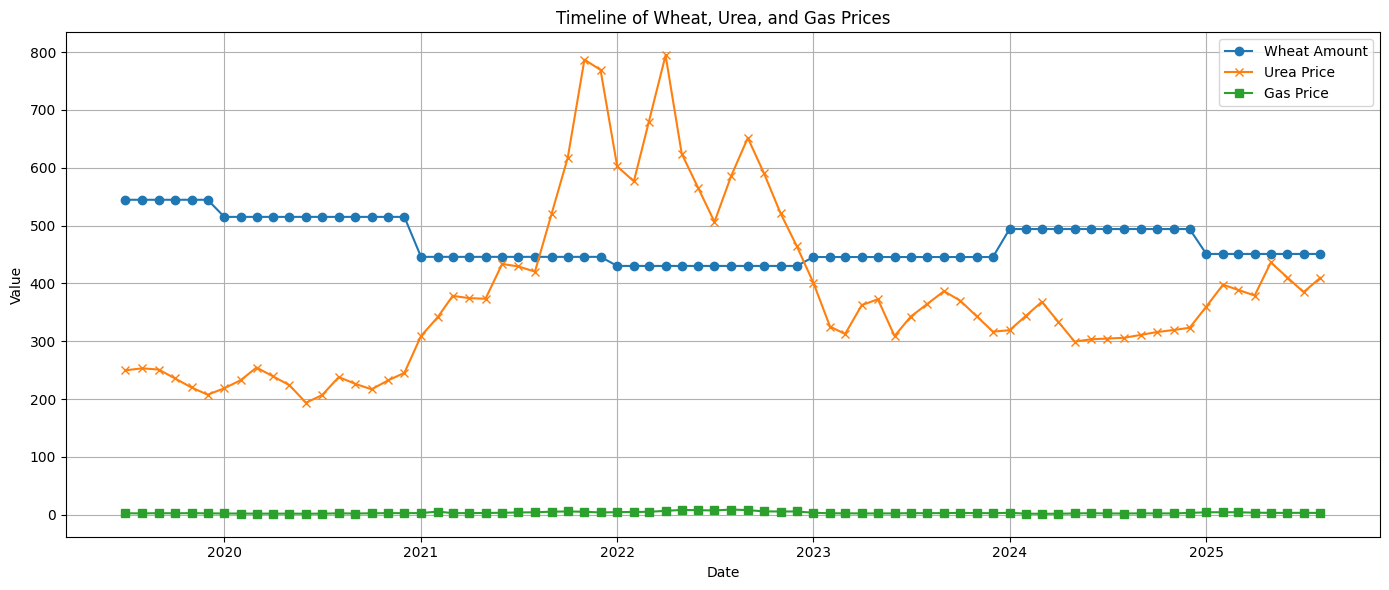

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# لود فایل
merged = pd.read_csv("/content/merged_monthly_prepared.csv", parse_dates=['Date'])

# رسم نمودار
plt.figure(figsize=(14,6))
plt.plot(merged['Date'], merged['Wheat_Amount'], label='Wheat Amount', marker='o')
plt.plot(merged['Date'], merged['Urea_Price'], label='Urea Price', marker='x')
plt.plot(merged['Date'], merged['Gas_Price'], label='Gas Price', marker='s')

plt.title('Timeline of Wheat, Urea, and Gas Prices')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
print(gas_monthly.head(10))
print(gas_monthly.tail(10))


        Date  Gas_Price
0 1997-01-01       3.45
1 1997-02-01       2.15
2 1997-03-01       1.89
3 1997-04-01       2.03
4 1997-05-01       2.25
5 1997-06-01       2.20
6 1997-07-01       2.19
7 1997-08-01       2.49
8 1997-09-01       2.88
9 1997-10-01       3.07
          Date  Gas_Price
334 2024-11-01       2.12
335 2024-12-01       3.01
336 2025-01-01       4.13
337 2025-02-01       4.19
338 2025-03-01       4.12
339 2025-04-01       3.42
340 2025-05-01       3.12
341 2025-06-01       3.02
342 2025-07-01       3.20
343 2025-08-01       2.91
